In [1]:
%pylab inline
from __future__ import print_function, division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import scipy.stats
from MTD import *
import brewer2mpl
from scipy.stats.mstats import zscore as zscore

Populating the interactive namespace from numpy and matplotlib


In [2]:
#read data
%run dataframe_ts.py
#TS_df = pd.read_csv('../Data/TS_FIRReg_df.csv')
TS_df.head()

,Time,Subject,Condition,Dataset,Run,FFA,PPA,VC
0,1,512,FH,FIR,1,-0.496563,-0.022461,-0.214295
1,2,512,FH,FIR,1,0.086209,0.209026,-0.404957
2,3,512,FH,FIR,1,-0.096103,-0.470802,-1.028810
3,4,512,FH,FIR,1,-0.225747,-0.464820,-0.317825
4,5,512,FH,FIR,1,0.646156,-0.532554,-0.268533


In [21]:
Subjects = [503,505,508,509,510,512,513,516,517,518,519,523,527,528,529,530,531,532,534,536,537,539,540,542,546,547,549,550]
Conditions = ['FH', 'Fp', 'HF', 'Hp']
#MotorMapping = [1, 2]
corr_df = pd.DataFrame(columns=['Subj', 'Condition', 'Run','Window', 'MTD-FFA-VC', 'MTD-PPA-VC', 'corr-FFA-VC', 'corr-PPA-VC'], dtype=float)
#'Run', 'FFA-M','FFA-NM', 'PPA-M', 'PPA-NM',
Runs = [1, 2, 3, 4]
#motor mapping 1, RH-Face LH-Scene
#motor mapping 2, RH-Scene, LH-Face

# block start times and TRs:
# 1.50 42.00 82.50 121.50
# 0, 27, 54, 80
TR_index = np.arange(0,98)
TR_index[TR_index!=0] == False 
TR_index[0:12] = True
TR_index[24:39] = True
TR_index[51:66] = True
TR_index[80:92] = True

i=1
for s, sub in enumerate(Subjects):
    for c, cond in enumerate(Conditions):
        for run in Runs:
            PPA_ts = np.array(TS_df[(TS_df['Subject'] == str(sub)) & (TS_df['Condition'] == cond) & (TS_df['Run'] == run)]['PPA'])
            FFA_ts = np.array(TS_df[(TS_df['Subject'] == str(sub)) & (TS_df['Condition'] == cond) & (TS_df['Run'] == run)]['FFA'])
            VC_ts = np.array(TS_df[(TS_df['Subject'] == str(sub)) & (TS_df['Condition'] == cond) & (TS_df['Run'] == run)]['VC'])
            
            #cal coupling
            #cfv = np.corrcoef(np.array([FFA_ts, VC_ts]))[0,1]
            #cfp = np.corrcoef(np.array([PPA_ts, VC_ts]))[0,1]
            
            for w in np.arange(1,11):
                corr_df.loc[i, 'Condition'] = cond
                corr_df.loc[i, 'Subj'] = sub
                corr_df.loc[i, 'Run'] = run
                corr_df.loc[i, 'Window'] = w
                corr_df.loc[i,'MTD-FFA-VC'] = np.nanmean(coupling(np.array([FFA_ts, VC_ts]).T, w)[1][:,0,1][TR_index])
                corr_df.loc[i,'MTD-PPA-VC'] = np.nanmean(coupling(np.array([PPA_ts, VC_ts]).T, w)[1][:,0,1][TR_index])
                
                sT = pd.rolling_mean(np.array([FFA_ts, VC_ts]).T,w, center = True)
                sT[np.isnan(sT)] = 0
                corr_df.loc[i,'corr-FFA-VC'] = np.corrcoef(sT.T)[0,1]
                
                sT = pd.rolling_mean(np.array([PPA_ts, VC_ts]).T,w, center = True)
                sT[np.isnan(sT)] = 0
                corr_df.loc[i,'corr-PPA-VC'] = np.corrcoef(sT.T)[0,1]
                
                i = i+1

In [22]:
stat_df = corr_df.groupby(['Subj','Condition','Window']).mean().reset_index()
#stat_df.head()

mean_df = stat_df.groupby(['Condition','Window']).mean().reset_index()
sem_df = stat_df.groupby(['Condition','Window']).sem().reset_index()
mean_df.head()
#sem_df.head()

,Condition,Window,Subj,Run,MTD-FFA-VC,MTD-PPA-VC,corr-FFA-VC,corr-PPA-VC
0,FH,1,526.785714,2.5,0.188175,0.049650,0.169693,0.012725
1,FH,2,526.785714,2.5,0.176332,0.075118,0.186213,0.004902
2,FH,3,526.785714,2.5,0.175796,0.081422,0.193931,0.001255
3,FH,4,526.785714,2.5,0.152089,0.056311,0.196788,0.003869
4,FH,5,526.785714,2.5,0.151326,0.053747,0.194960,0.011151


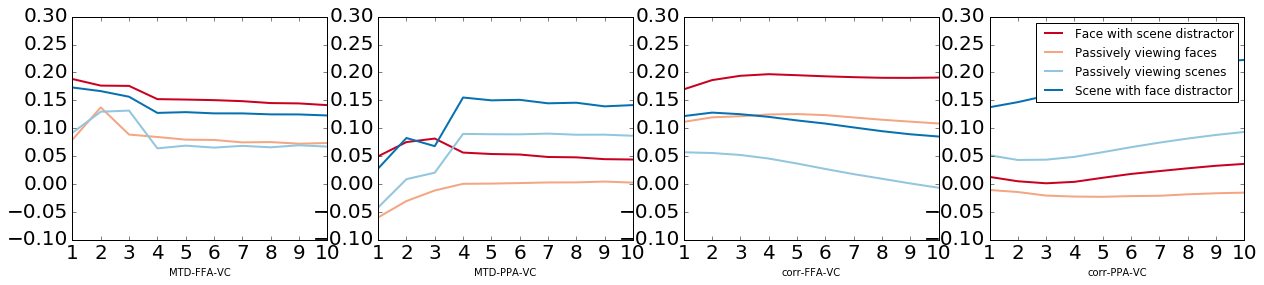

In [23]:
plt.rc('xtick', labelsize=20)  
plt.rc('ytick', labelsize=20) 
ROIpairs = ['MTD-FFA-VC', 'MTD-PPA-VC','corr-FFA-VC', 'corr-PPA-VC']
Conditions =['FH', 'Fp', 'Hp', 'HF']
Labels = ['Face with scene distractor', 'Passively viewing faces ', 'Passively viewing scenes', 'Scene with face distractor']
x = np.arange(1,11)
#get colormap
cmap = brewer2mpl.get_map('RdBu','diverging', 4)
plt.figure(1)
plt.figure(figsize=(21,4))
for r, roi in enumerate(ROIpairs):
    plt.subplot(1, 4, r+1)
    
    for i, c in enumerate(Conditions):
        y = np.array(mean_df[(mean_df['Condition'] == c)][roi])
        error = np.array(sem_df[(mean_df['Condition'] == c)][roi])
        plt.plot(x, y, color = cmap.hex_colors[i], linewidth=2  )
       
        #plt.fill_between(x, y-1*error, y+1*error, alpha=0.2, edgecolor=cmap.hex_colors[i], 
        #             facecolor=cmap.hex_colors[i], label=c)

        plt.ylim(-0.1,0.3)
        plt.xlim(1, 10)
        plt.xlabel(roi)
plt.legend(Labels)
plt.show()

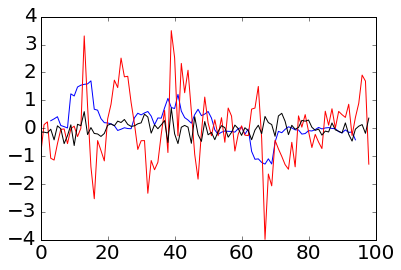

In [6]:
plt.plot(coupling(np.array([FFA_ts, VC_ts]).T, 7)[1][:,0,1])
plt.plot(FFA_ts, 'r')
plt.plot(PPA_ts, 'k')

In [20]:
A = pd.rolling_mean(np.array([FFA_ts, VC_ts]).T,7, center = True)
A[np.isnan(A)] = 0
np.corrcoef(A.T)[0,1]

0.23508497142438309

In [17]:
np.isnan(a)

array([ True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True], dtype=bool)